<a href="https://colab.research.google.com/github/AntonioHallgass/corso_AI_2025/blob/main/appello_23.10.2023/MetodiAI_Fis2023_ProvaPratica_23_10_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prova Pratica - Metodi AI e Machine Learning per la fisica
### 23.10.2023 - AA 2022/23 - Docente: S. Giagu


> **Regole:**

*   **tempo a disposizione:**
* prova completa 2h30'

*   compilare con i vostri dati i campi della cella che segue e poi eseguire la cella verificando che i dati printati corrispondano. L'esecuzione della cella scarica anche il dataset necessario
*   risolvere i quesiti/compiti indicati nella cella *Descrizione del compito* realtivi alla tipologia di prova che si vuole sostenere (completa o recupero esonero) usando questo notebook
*   una volta completato il compito scaricare il notebook localmente e spedirlo via e-mail a *stefano.giagu@uniroma1.it*

# Descrizione del compito:

Viene fornito un dataset costituto da due array numpy contenuti nel file compresso *pp_23.10_2023_dataset.npz*. Il file contiene gli array numpy *data* e *labels*. Il primo contiene 3960 esempi, ognuno costituito da 8 features, il secondo le label associate (0,1).

<p>
<p>

###È richiesto di risolvere i seguenti task:###

1.   leggere il dataset, e plottare in forma di istogramma le distribuzioni di ciascuna osservabile per gli eventi di classe 0 e quelli di classe 1 colorandoli con colori diversi;
2.   allenare un classificatore basato su una rete neurale di tipo MLP-shallow con un solo layer nascosto con non più di 30 neuroni nel layer nascosto;
3.   stimare le prestazioni del modello allenato in termini di *accuracy*, *matrice di confusione*, e *curva ROC*;
4.  allenare 10 modelli identici a quello appena allenato in modo tale che:
*   ogni modello abbia pesi iniziali settati in modo random (eg sia ottenuto istanziando ogni volta una nuova istanza del modello);
*   il modello venga allenato per un numero fissato di epoche pari a 20 epoche;
*   alla fine del training di ogni modello vengano salvati i pesi del modello in un opportuno vettore numpy:

In [9]:
#@ Dati Personali
import os

Nome = 'Stefano'  #@param {type: "string"}
Cognome = 'Giagu' #@param {type: "string"}
NumeroMatricola = 1977520 #@param {type: "number"}

if NumeroMatricola == 12345678:
  print('\033[1;31m Inserisci il numero di matricola corretto!!!!')
else:
  print('Download dataset ...')
  !wget http://giagu.web.cern.ch/giagu/CERN/pp_23.10.2023_dataset.npz
  print('Done')

Download dataset ...
--2025-06-28 10:31:54--  http://giagu.web.cern.ch/giagu/CERN/pp_23.10.2023_dataset.npz
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.185.5.88, 137.138.55.232, 188.185.50.104, ...
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.185.5.88|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://giagu.web.cern.ch/giagu/CERN/pp_23.10.2023_dataset.npz [following]
--2025-06-28 10:31:55--  https://giagu.web.cern.ch/giagu/CERN/pp_23.10.2023_dataset.npz
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.185.5.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 285626 (279K)
Saving to: ‘pp_23.10.2023_dataset.npz.2’

pp_23.10.2023_datas 100%[===================>] 278.93K   450KB/s    in 0.6s    

2025-06-28 10:31:56 (450 KB/s) - ‘pp_23.10.2023_dataset.npz.2’ saved [285626/285626]

Done


5.   visualizzare la traiettoria di addestramento dei diversi modelli in un unico plot bidimensionale. Visualizzare la traiettoria di addestramento di un modello consiste nel graficare un punto per ogni epoca di addestramento del modello, punto corrispondente al valore dei parametri del modello alla fine dell'epoca in uno spazio a dimensione ridotta rappresentativo dei parametri del modello. Per ridurre la dimensione dello spazio dei parametri del modello si deve applicare una trasfromazione PCA a 2 componenti al vettore dei pesi salvati per oguna delle 20 epoche. Fatto questo si possono graficare le due componenti principali tramite uno scatter plot, colorando ciaascun punto con l'indice di epoca (un numero intero che va da 0 a 19). È richiesto di graficare le traiettorie di tutti e 10 i modelli addestrati al punto 4 nello stesso grafico.

Un esempio di traiettoria di addestramento è il seguente, in cui i colori variano dal viola scuro (prima epoca) al giallo chiaro (ultima epoca):

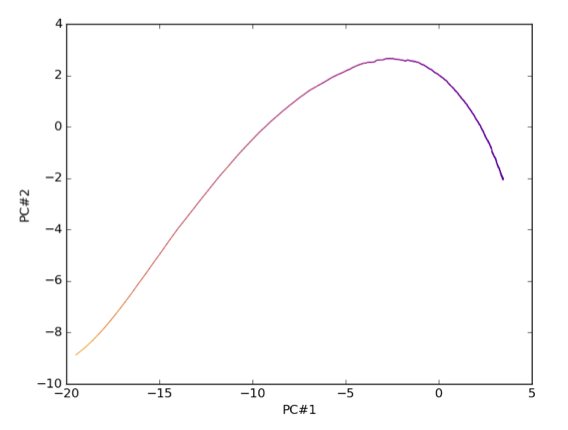


* commentare opportunamente i risultati ottenuti in ogni punto.

In [10]:
# Esempio codice per accedere ai pesi del modello e salvarli in un vettore numpy 1D:

vtmp = np.empty(0)
for name, param in model.named_parameters():
  vtmp = np.concatenate((vtmp,param.flatten().cpu().detach().numpy()))

NameError: name 'model' is not defined

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from sklearn.metrics import accuracy_score

In [21]:
dati = np.load('pp_23.10.2023_dataset.npz')
X = dati['data']
y=dati['labels']
print(X.shape)
print(y.shape)

(3960, 8)
(3960,)


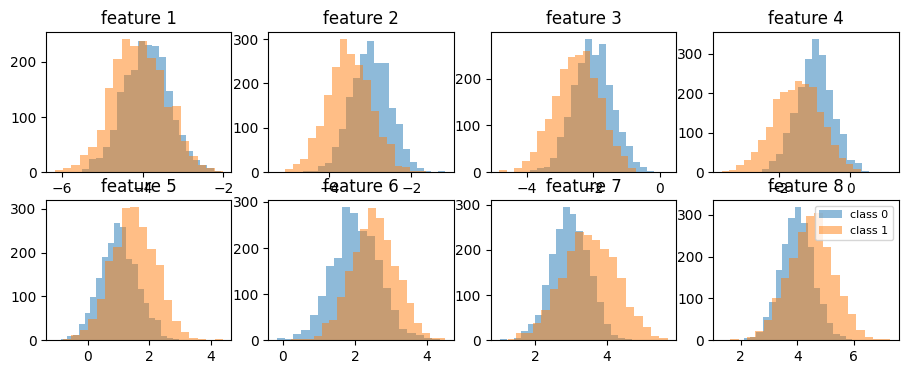

In [41]:
X_0=X[y==0,:]
X_1=X[y==1,:]
#print(X_0.shape,X_1.shape)

figure = plt.figure(figsize=(11, 4))
for i in range(8):
  ax=figure.add_subplot(2,4,i+1)
  ax.hist(X_0[:,i],bins=20,alpha=0.5,label='class 0')
  ax.hist(X_1[:,i],bins=20,alpha=0.5,label='class 1')
  ax.set_title('feature {}'.format(i+1))
plt.legend(prop={'size': 8})
plt.show()

In [163]:
class MLP(nn.Module):
  def __init__(self, input_dim=8, hidden_dim=30, output_dim=1):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_dim, output_dim)
  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    return x
model=MLP()
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
summary(model, (1,8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 30]             270
              ReLU-2                [-1, 1, 30]               0
            Linear-3                 [-1, 1, 1]              31
Total params: 301
Trainable params: 301
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [195]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size=0.2, random_state=42)
x_train=torch.from_numpy(X_train).float()
x_val=torch.from_numpy(X_val).float()
y_train=torch.from_numpy(Y_train).float()
y_val=torch.from_numpy(Y_val).float()
print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)
train_ds=TensorDataset(x_train,y_train)
train_dl=DataLoader(train_ds,batch_size=32,shuffle=True)
val_ds=TensorDataset(x_val,y_val)
val_dl=DataLoader(val_ds,batch_size=32,shuffle=True)


criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'using device: {device}')

torch.Size([3168, 8]) torch.Size([3168])
torch.Size([792, 8]) torch.Size([792])
using device: cpu


In [196]:
import os
os.makedirs('results', exist_ok=True)  # Create the directory if it doesn't exist
torch.save(best_weights, 'results/best_weights.pth')


In [197]:
num_epochs=65
best_val_acc = 0.0
#epochs_since_best_val_acc = 0
train_curve=[]
val_curve=[]
#lr_curve=[]

for epoch in range(num_epochs):

    model.train()
    tmp_loss = 0

    for (data, target) in train_dl:

        output = model(data)
        loss = criterion(output.squeeze(1), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tmp_loss += loss.detach().numpy()

    #if epoch > 20:
     #scheduler.step()

    #lr_curve.append(optimizer.param_groups[0]['lr'])
    train_curve.append(tmp_loss/len(train_dl))
    print(f"Epoch {epoch+1}/{num_epochs}, train_loss: {tmp_loss/len(train_dl):.6f}")

    model.eval()
    with torch.no_grad():
        val_acc = 0.0
        #val_total = 0
        val_loss = 0
        for data, target in val_dl:
            output = model(data)
            val_loss += criterion(output.squeeze(1), target).item()

            output_np = output.squeeze(1).cpu().numpy()
            target_np = target.cpu().numpy()
            predicted = (output_np >= 0.5).astype(int)
            val_acc += accuracy_score(target_np, predicted)

            probs = torch.sigmoid(output).squeeze()
        val_acc /=  len(val_dl)
        val_loss /= len(val_dl)
        val_curve.append(val_loss)

        print(f"val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")#, lr: {optimizer.param_groups[0]['lr']:.3e}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
        #    epochs_since_best_val_acc = 0
            best_weights = model.state_dict()
            torch.save(best_weights, 'results/best_weights.pth')
            print("Best!")
            best_epoch = epoch
        #else:
        #    epochs_since_best_val_acc += 1

        # Check if early stopping is necessary
        #if epochs_since_best_val_acc >= patience:
        #    print("Early stopping!")
        #    break


Epoch 1/20, train_loss: 0.233401
val_loss: 0.2604, val_acc: 0.8962
Best!
Epoch 2/20, train_loss: 0.234474
val_loss: 0.2499, val_acc: 0.8979
Best!
Epoch 3/20, train_loss: 0.234547
val_loss: 0.2494, val_acc: 0.8983
Best!
Epoch 4/20, train_loss: 0.233700
val_loss: 0.2617, val_acc: 0.8875
Epoch 5/20, train_loss: 0.233976
val_loss: 0.2504, val_acc: 0.8967
Epoch 6/20, train_loss: 0.229634
val_loss: 0.2546, val_acc: 0.9046
Best!
Epoch 7/20, train_loss: 0.231237
val_loss: 0.2531, val_acc: 0.8950
Epoch 8/20, train_loss: 0.231329
val_loss: 0.2509, val_acc: 0.8950
Epoch 9/20, train_loss: 0.229534
val_loss: 0.2490, val_acc: 0.9000
Epoch 10/20, train_loss: 0.229110
val_loss: 0.2619, val_acc: 0.8996
Epoch 11/20, train_loss: 0.234804
val_loss: 0.2500, val_acc: 0.8950
Epoch 12/20, train_loss: 0.228331
val_loss: 0.2502, val_acc: 0.8971
Epoch 13/20, train_loss: 0.228079
val_loss: 0.2522, val_acc: 0.9029
Epoch 14/20, train_loss: 0.227503
val_loss: 0.2881, val_acc: 0.8933
Epoch 15/20, train_loss: 0.231967

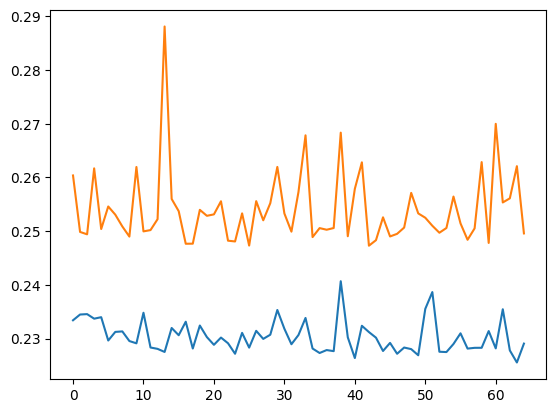

In [198]:
plt.plot(train_curve)
plt.plot(val_curve)
plt.show()

In [199]:
model.load_state_dict(torch.load('results/best_weights.pth'))
model.eval()

MLP(
  (fc1): Linear(in_features=8, out_features=30, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=30, out_features=1, bias=True)
)

In [200]:
from sklearn.metrics import roc_curve, auc

all_targets = []
all_probs = []

with torch.no_grad():
    for data, target in val_dl:
        output = model(data)
        probs = torch.sigmoid(output).squeeze()  # output → probabilità
        all_probs.extend(probs.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# Calcola ROC e AUC
fpr, tpr, _ = roc_curve(all_targets, all_probs)
roc_auc = auc(fpr, tpr)
print(f"Final AUC: {roc_auc:.4f}")

Final AUC: 0.9624


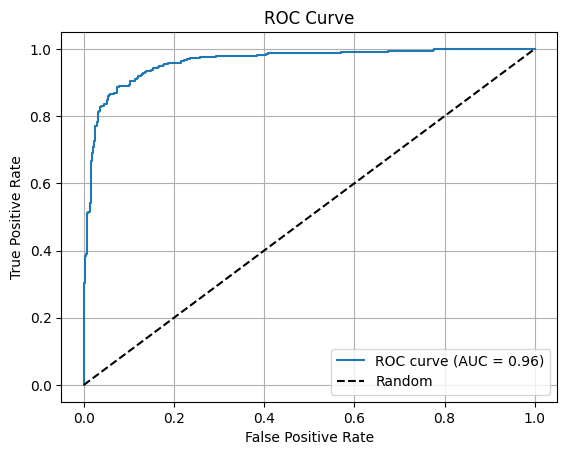

In [201]:
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [202]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

def CM(model, test_loader, threshold=0.5):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)

            # Convert to numpy
            outputs = outputs.squeeze().numpy()  # shape: (batch,)
            targets = targets.squeeze().numpy()  # shape: (batch,)

            # Apply threshold to get binary predictions
            predicted = (outputs >= threshold).astype(int)

            y_true.extend(targets.astype(int))
            y_pred.extend(predicted)

    cm = confusion_matrix(y_true, y_pred, normalize="true")

    return np.array(y_true), np.array(y_pred), cm


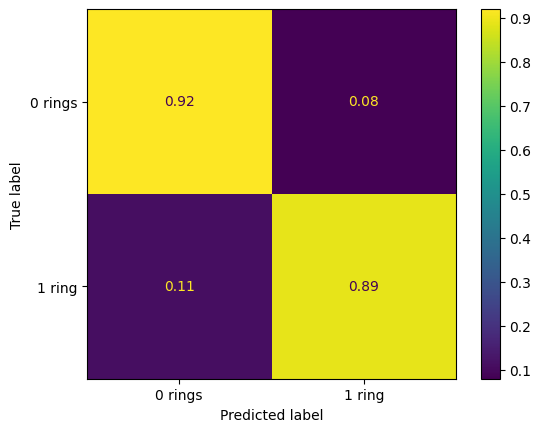

In [203]:
_,_,cm=CM(model, val_dl)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["0 rings", "1 ring"])
disp.plot()

plt.show()

In [221]:
import numpy as np

all_weights = []
num_epochs = 20

for i in range(10):
    print(f'MODELLO NUMERO {i}')
    model = MLP()
    optimizer = optim.Adam(model.parameters(), lr=0.003)

    train_curve = []
    val_curve = []

    weights_per_epoch = []  # qui salvo i pesi a ogni epoca per questo modello

    for epoch in range(num_epochs):
        model.train()
        tmp_loss = 0

        for data, target in train_dl:
            output = model(data)
            loss = criterion(output.squeeze(1), target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tmp_loss += loss.detach().item()

        train_curve.append(tmp_loss / len(train_dl))
        print(f"Epoch {epoch+1}/{num_epochs}, train_loss: {tmp_loss / len(train_dl):.6f}")

        # Estraggo i pesi e concateno in vettore
        vtmp_list = []
        for name, param in model.named_parameters():
            vtmp_list.append(param.flatten().cpu().detach().numpy())
        vtmp = np.concatenate(vtmp_list)

        weights_per_epoch.append(vtmp)  # salvo i pesi di questa epoca

    all_weights.append(weights_per_epoch)  # salvo i pesi di tutte le epoche di questo modello

# Converto in numpy array tridimensionale: shape (10, num_epochs, num_parametri)
all_weights = np.array(all_weights)
print("Shape all_weights:", all_weights.shape)

MODELLO NUMERO 0
Epoch 1/20, train_loss: 0.639863
Epoch 2/20, train_loss: 0.547172
Epoch 3/20, train_loss: 0.512623
Epoch 4/20, train_loss: 0.483868
Epoch 5/20, train_loss: 0.470930
Epoch 6/20, train_loss: 0.454841
Epoch 7/20, train_loss: 0.440794
Epoch 8/20, train_loss: 0.423568
Epoch 9/20, train_loss: 0.403949
Epoch 10/20, train_loss: 0.392926
Epoch 11/20, train_loss: 0.374414
Epoch 12/20, train_loss: 0.355602
Epoch 13/20, train_loss: 0.338902
Epoch 14/20, train_loss: 0.329558
Epoch 15/20, train_loss: 0.325267
Epoch 16/20, train_loss: 0.311736
Epoch 17/20, train_loss: 0.310437
Epoch 18/20, train_loss: 0.287199
Epoch 19/20, train_loss: 0.287039
Epoch 20/20, train_loss: 0.288489
MODELLO NUMERO 1
Epoch 1/20, train_loss: 0.611463
Epoch 2/20, train_loss: 0.532410
Epoch 3/20, train_loss: 0.494983
Epoch 4/20, train_loss: 0.479221
Epoch 5/20, train_loss: 0.462671
Epoch 6/20, train_loss: 0.445379
Epoch 7/20, train_loss: 0.432288
Epoch 8/20, train_loss: 0.414456
Epoch 9/20, train_loss: 0.40044

In [236]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_results = []  # per salvare i risultati di tutti i modelli
for j in range(10):
    pca = PCA(n_components=2)
    weight_pca = pca.fit_transform(all_weights[j, :, :])  # (num_epochs, 2)
    pca_results.append(weight_pca)
PCAA=np.array(pca_results)
print(PCAA.shape)
for j in range(10):
  plt.scatter(PCAA[j,:,0],PCAA[j,:,1],c=np.arange(num_epochs))
plt.show()


SyntaxError: positional argument follows keyword argument (ipython-input-236-242964270.py, line 11)

Shape PCAA: (10, 20, 2)


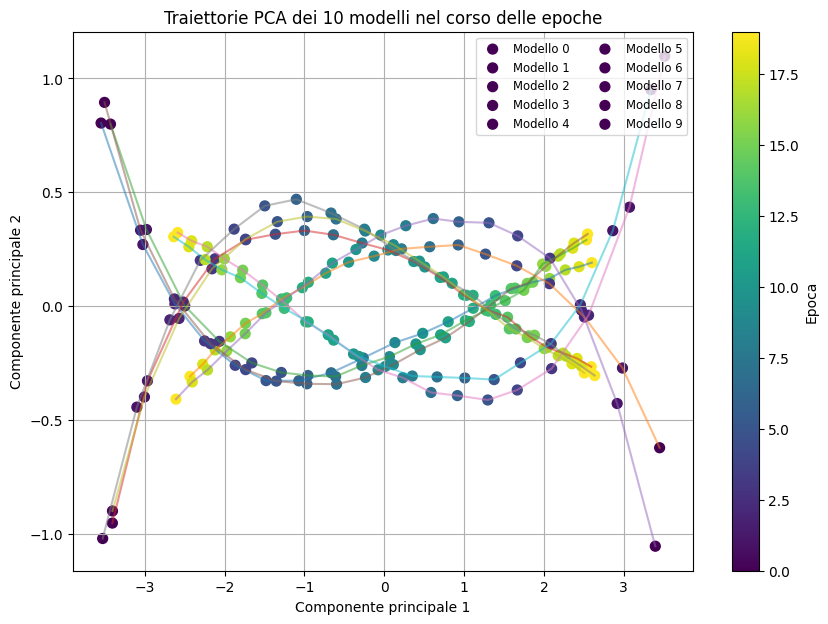

In [237]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

num_models = 10
num_epochs = all_weights.shape[1]

pca_results = []

for j in range(num_models):
    pca = PCA(n_components=2)
    weight_pca = pca.fit_transform(all_weights[j, :, :])
    pca_results.append(weight_pca)

PCAA = np.array(pca_results)
print("Shape PCAA:", PCAA.shape)  # dovrebbe essere (10, num_epochs, 2)

plt.figure(figsize=(10, 7))

for j in range(num_models):
    x = PCAA[j, :, 0]
    y = PCAA[j, :, 1]
    epochs = np.arange(num_epochs)

    sc = plt.scatter(x, y, c=epochs, cmap='viridis', s=50, label=f'Modello {j}')
    plt.plot(x, y, alpha=0.5)

cbar = plt.colorbar(sc)
cbar.set_label('Epoca')

plt.title("Traiettorie PCA dei 10 modelli nel corso delle epoche")
plt.xlabel("Componente principale 1")
plt.ylabel("Componente principale 2")
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.grid(True)

(5,)
(5,)
